# Phase 3: Model Analysis and Diagnostics

This notebook loads the best performing model from MLflow and performs a deep dive analysis:
1. **Confusion Matrix**: To understand False Positives v False Negatives
2. **Feature Importance**: To see which features drive the decision
3. **Probability Distributions**: To see how confident the model is

In [9]:
import sys
from pathlib import Path
# Configuration
PROJECT_ROOT = Path.cwd().parent
EXPERIMENT_NAME = "Loan_Default_Prediction"
MLFLOW_TRACKING_URI = "file://" + str(PROJECT_ROOT / "mlruns") 

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from src.preprocessing import TARGET_COLUMN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"Tracking URI: {MLFLOW_TRACKING_URI}")


Tracking URI: file:///Users/bharathbeeravelly/Desktop/mlops-loan-payback/mlruns


## 1. Load the Best Model automatically
Instead of hardcoding a Run ID, we ask MLflow for the winner

In [2]:
client = mlflow.tracking.MlflowClient()

# Get ExperimentID
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
experiment_id = experiment.experiment_id


In [3]:
# Search for the best run (Highest AUC)
runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="",
    order_by=["metrics.roc_auc DESC"],
    max_results=1
)

best_run = runs[0]
best_run_id = best_run.info.run_id
best_auc = best_run.data.metrics['roc_auc']
params = best_run.data.params

In [4]:
print(f'Best Run ID: {best_run_id}')
print(f'AUC: {best_auc:.4f}')
print(f'Parameters: {params}')


Best Run ID: 76c9116967a5483d8632494a9a7c1af1
AUC: 0.9108
Parameters: {'penalty': 'l2', 'class_weight': 'balanced', 'model': 'LogisticRegression', 'C': '1.0', 'strategy': 'targeted'}


In [7]:
# Load the model (Pipeline)
model_uri = f"runs:/{best_run_id}/model"
pipeline = mlflow.sklearn.load_model(model_uri)
print("Model loaded successfully!")


Model loaded successfully!


In [10]:
# Load data
data_path = PROJECT_ROOT / "data" / "processed" / "local_train.csv"
df = pd.read_csv(data_path)

In [11]:
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Validation Set size: {X_val.shape}")

Validation Set size: (95039, 11)


## 3. Confusion Matrix 

This tells us where the model is making mistakes

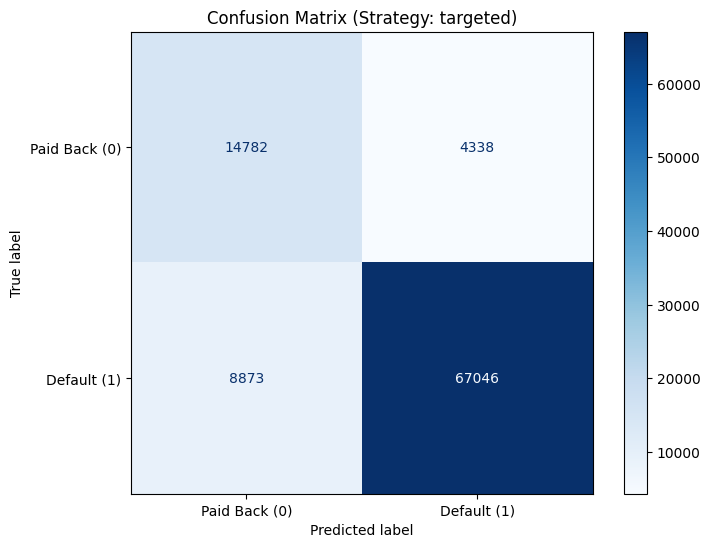

In [12]:
# Get Prediction
y_pred = pipeline.predict(X_val)
y_prob = pipeline.predict_proba(X_val)[:, 1]

# Plot
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Paid Back (0)", "Default (1)"])

fig, ax = plt.subplots(figsize = (8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title(f"Confusion Matrix (Strategy: {params['strategy']})")
plt.grid(False)
plt.show()

### Interpretation Guide
* **Top-Left:** Correctly predicted "Paid Back"
* **Bottom-Right:** Correctly predicted "Default"
* **Top-Right (False Positives):** Predicted Default, but they Paid Back.
* **Bottom-Left (False Negative):** Predicted Paid Back, but they Defaulted

## 4. Feature Importance (Coefficients)
Since this is Logistic Regression, we can look at the **Coefficients** to see which features increase or decrease risk

In [13]:
# Extract the classifier and preprocessor from the pipeline
classifier = pipeline.named_steps['classifier']
preprocessor = pipeline.named_steps['preprocessor']

# Get Feature Names
feature_names = preprocessor.get_feature_names_out()

In [14]:
# Create a Dataframe
coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': classifier.coef_[0],
    'Abs_Coefficient': np.abs(classifier.coef_[0])
})

In [15]:
# Sort by absolute impact
coefs = coefs.sort_values(by='Abs_Coefficient', ascending=False).head(15)

/var/folders/vh/y8k1dgkj76s01krzn8qtn3nw0000gn/T/ipykernel_58299/1235331134.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefs, x = 'Coefficient', y='Feature', palette='coolwarm')


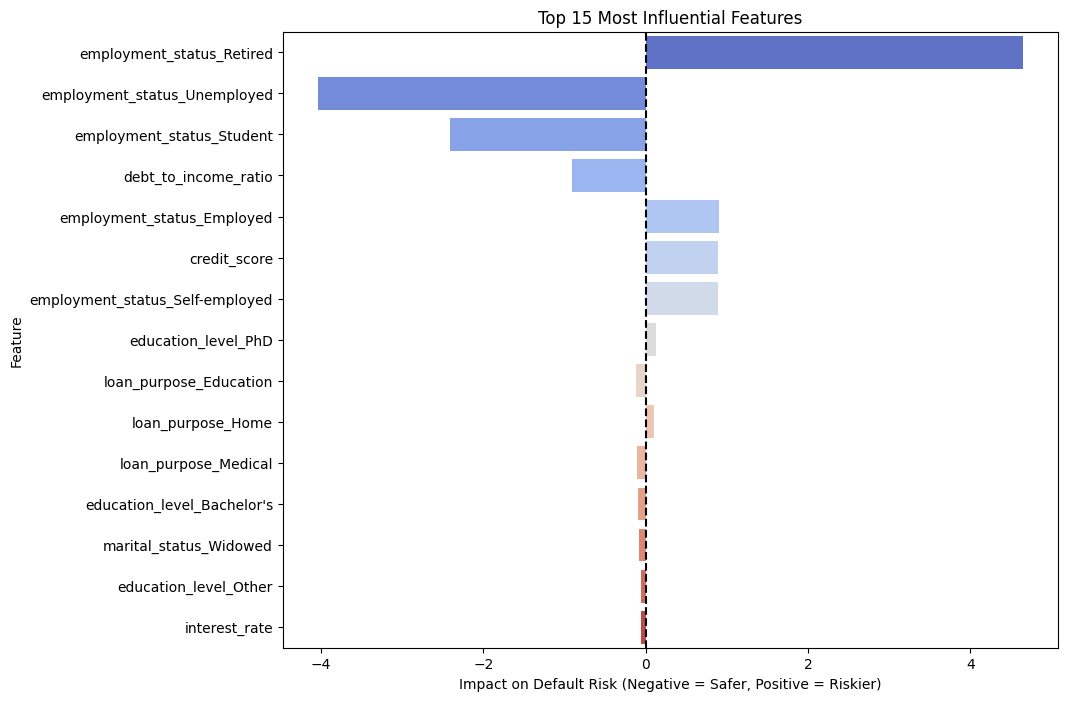

In [16]:
# Plot
plt.figure(figsize=(10,8))
sns.barplot(data=coefs, x = 'Coefficient', y='Feature', palette='coolwarm')
plt.title("Top 15 Most Influential Features")
plt.xlabel("Impact on Default Risk (Negative = Safer, Positive = Riskier)")
plt.axvline(0, color='black', linestyle='--')
plt.show()

## 5. Prediction Distribution
How confident is the model? Does it separate the classes well?


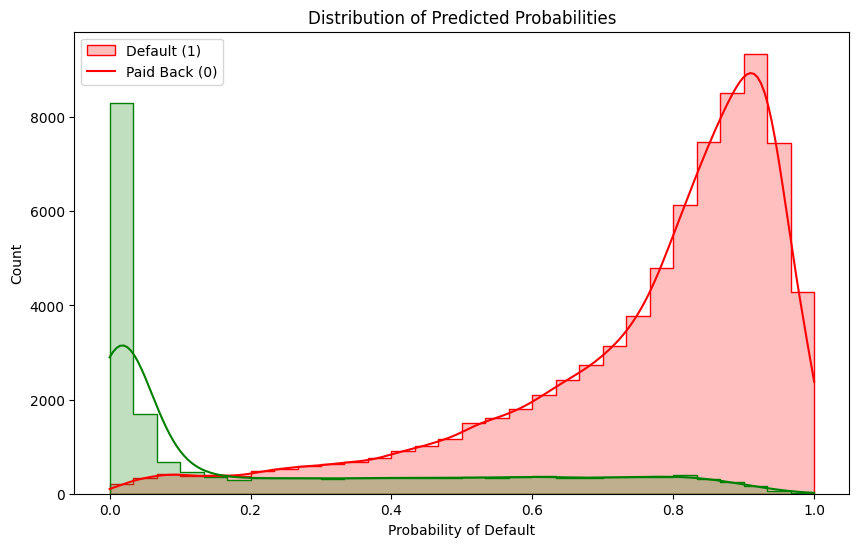

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(x=y_prob, hue=y_val, bins=30, kde=True, palette={0: "green", 1: "red"}, element="step")
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Probability of Default")
plt.legend(["Default (1)", "Paid Back (0)"])
plt.show()
